In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.colors import ListedColormap
import seaborn as sns

import statsmodels.api as sm

from stargazer.stargazer import Stargazer, LineLocation 

In [2]:
style.use('ggplot')
sns.set_theme()

In [3]:
# df = pd.read_excel("data/PE_merged (12-11-2022).xlsx", sheet_name="PE (merged)")

# Cleaning / Preprocessing

## PE Risbano Data

In [4]:
pe = pd.read_excel("data/PE_merged (12-11-2022).xlsx", sheet_name="PE")

In [5]:
pe['date'] = pd.to_datetime(pe['study_date'], format="%Y%m%d")

In [6]:
pe.rename(columns={'patient_name': 'pe_number'}, inplace=True)

In [7]:
tuples = list(zip(pe['pe_number'], pe['date']))
new_idx = pd.MultiIndex.from_tuples(tuples, names=['PE Number', 'Study Date'])
pe.index = new_idx

In [8]:
pe['clot_burden_additive'] = pe.iloc[:, list(pe.columns).index("Apical_R-S1"):list(pe.columns).index("Posterior_Basal_L-S10")+1].sum(axis=1)
pe['clot_burden_additive'].head()

PE Number  Study Date
PE1        2014-01-07    205.535670
PE12       2021-12-03     75.827757
           2020-12-18    190.970071
PE14       2018-12-19    126.536620
PE15       2020-09-18     81.828530
Name: clot_burden_additive, dtype: float64

## iCPET Data

In [9]:
cl = pd.read_excel("data/PE_merged (12-11-2022).xlsx", sheet_name="Clinical Data")

In [10]:
cl['date'] = pd.to_datetime(cl['1st iCPET'])
cl['Peak  PVR (WU)'] = pd.to_numeric(cl['Peak  PVR (WU)'])

In [11]:
cl.rename(columns={'PE Number clean': 'pe_number'}, 
          inplace=True)

In [12]:
cl['Resolved'] = cl['Resolved PE'].astype('category')
cl['Resolved'].cat.categories

Int64Index([0, 1], dtype='int64')

In [13]:
cl['Resolved'] = cl['Resolved'].cat.rename_categories({0: 'Chronic', 1: 'Resolved'})
cl['Resolved'].cat.categories

Index(['Chronic', 'Resolved'], dtype='object')

## Merge Data

In [14]:
pe.sort_values(by=['date'], inplace=True)
cl.sort_values(by=['date'], inplace=True)

# Need the clinical data to be the left df
# Merging on pe number and closest date
df = pd.merge_asof(cl, pe, on='date', by='pe_number', direction='nearest')
df.sort_values(by=['pe_number'], inplace=True)

In [15]:
df.to_csv('output/merged.csv')

C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


# Correlation Plots

# Research questions

## clot characteristics

In [21]:
fields = [
    'pe_number',
    'clot_burden_additive',
    'Resolved',
    'VE/VCO2 at AT',
    'Peak  Measured mPAP (mmHg)',
    'Peak  PVR (WU)',
    'Peak  C(A-V)O2',
    'Peak  P(A-a)O2',
    'Peak  Fick CO',
    'Peak  VD/VT',
]

df_sub_long = df[fields].melt(id_vars=['pe_number', 'clot_burden_additive', 'Resolved'])
df_sub_long.head()

,pe_number,clot_burden_additive,Resolved,variable,value
0,PE1,205.535670,Resolved,VE/VCO2 at AT,31.0
1,PE11,NaN,Resolved,VE/VCO2 at AT,41.0
2,PE12,75.827757,Chronic,VE/VCO2 at AT,31.0
3,PE14,126.536620,Chronic,VE/VCO2 at AT,30.0
4,PE15,121.891910,Chronic,VE/VCO2 at AT,31.0


## body composition tissues effect on PE resolving and the PE clot burden?

In [231]:
def regression_one_model(df,Xindvars,Yvar, kind='ols', summary=True):
    """Performs regression model
    Args: 
        - df (pd.DataFrame): Dataframe
        - Xindvars (str or list): X variable names
        - Yvar (str): Y variable
        - summary (boolean): Whether you want the summary
    Returns:
        - Fitted regression model
    """
    if(type(Yvar)==str):
        Yvar=[Yvar]
    if(len(Yvar)!=1):
        print("Error: please enter a single y variable")
        return np.nan
    else:
        xf = df.dropna(subset=Yvar+Xindvars)[Xindvars+Yvar]
        Xexog = xf[Xindvars]
        if kind == 'ols':
            model = sm.OLS(xf[Yvar],Xexog)
        elif kind == 'logit':
            model = sm.Logit(xf[Yvar],Xexog)
        reg = model.fit()
    if(summary):
        return reg.summary2()
    else:
        return reg
    
def add_significance(value):
    if value <= 0.001:
        return '***'
    elif value <= 0.01:
        return '**'
    elif value <= 0.05:
        return '*'
    else:
        return 'ns'
    
def run_regression_group(df, indVarGroups, Y, kind='ols'):
    # Get model names
    model_names = list(indVarGroups.keys())
    
    # Initialize empty dataframe to store results
    results = pd.DataFrame()
    
    # Loop through models and perform regressions
    for model in model_names:
        temp_model = RegressionOneModel(df=df, 
                                        Xindvars=indVarGroups[model], 
                                        Yvar=Y, 
                                        summary=False,
                                        kind=kind)
        
        # Get results from coefficient table
        results_temp = temp_model.summary2().tables[1]
        
        # Add additional metrics
        results_temp['Model Name'] = model
        results_temp['Kind'] = temp_model.summary2().tables[0].iloc[0, 1]
        results_temp['yVar'] = temp_model.summary2().tables[0].iloc[1, 1]
        results_temp['xVar'] = results_temp.index
        results_temp['nobs'] = temp_model.summary2().tables[0].iloc[3, 1]
        results_temp['r2'] = temp_model.summary2().tables[0].iloc[6, 1]
        results_temp['r2_adj'] = temp_model.summary2().tables[0].iloc[0, 3]

        # Add to dataframe
        results = pd.concat([results, results_temp], axis=0)
    
    # Add significance    
    if 'P>|t|' in results.columns:
        results.rename(columns={'P>|t|': 'pval', 't': 'test_statistic'}, inplace=True)
    elif 'P>|z|' in results.columns:
        results.rename(columns={'P>|z|': 'pval', 'z': 'test_statistic'}, inplace=True)

    results['significance'] = results['pval'].apply(add_significance)
    
    # Add lookup column/index for excel
    results.index = [f"{k}_{m}_{y}_{x}" for k, m, y, x in zip(results['Kind'], results['Model Name'], results['yVar'], results['xVar'])]
        
    # Clean up and return
    del temp_model
    del results_temp
    return results

In [138]:
measures = [
    'volume', 
    'density', 
    'mass',
]

body_comps = [
    'visceral_fat', 
    'subcutaneous_fat', 
    'intermuscular_fat', 
    'muscle', 
    'bone',
]

body_vars = [measure + '_' + body_comp for body_comp in body_comps
                                       for measure in measures]
print(body_vars)

['volume_visceral_fat', 'density_visceral_fat', 'mass_visceral_fat', 'volume_subcutaneous_fat', 'density_subcutaneous_fat', 'mass_subcutaneous_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'mass_intermuscular_fat', 'volume_muscle', 'density_muscle', 'mass_muscle', 'volume_bone', 'density_bone', 'mass_bone']


In [214]:
df.columns

Index(['Enrollment ID', 'PH ID', 'iCPET ID', '1st iCPET', 'PE Study Number',
       'pe_number', 'DOB_x', 'Age', 'Gender', 'Race',
       ...
       'PB_larger_10', 'PV_diameter', 'A_diameter', 'PV/A', 'heart_volume',
       'airway_volume', 'airway_ratio', 'ILD_volume', 'ILD_ratio',
       'clot_burden_additive'],
      dtype='object', length=118)

In [229]:
bodyIndVarGroups = {
    'volume_visceral_fat_only': [
        'volume_visceral_fat',
    ], 
    'density_visceral_fat_only': [
        'density_visceral_fat',
    ], 
    'mass_visceral_fat_only': [
        'mass_visceral_fat',
    ], 
    'volume_subcutaneous_fat_only': [
        'volume_subcutaneous_fat',
    ], 
    'density_subcutaneous_fat_only': [
        'density_subcutaneous_fat',
    ], 
    'mass_subcutaneous_fat_only': [
        'mass_subcutaneous_fat',
    ], 
    'volume_intermuscular_fat_only': [
        'volume_intermuscular_fat',
    ], 
    'density_intermuscular_fat_only': [
        'density_intermuscular_fat',
    ], 
    'mass_intermuscular_fat_only': [
        'mass_intermuscular_fat',
    ], 
    'volume_muscle_only': [
        'volume_muscle',
    ], 
    'density_muscle_only': [
        'density_muscle',
    ], 
    'mass_muscle_only': [
        'mass_muscle',
    ], 
    'volume_bone_only': [
        'volume_bone',
    ], 
    'density_bone_only': [
        'density_bone',
    ], 
    'mass_bone_only': [
        'mass_bone',
    ],
    'VFAT_only': [
        measure+"_visceral_fat" for measure in measures
    ],
    'SFAT_only': [
        measure+"_subcutaneous_fat" for measure in measures
    ],
    'IFAT_only': [
        measure+"_intermuscular_fat" for measure in measures
    ],
    'Muscle_only': [
        measure+"_muscle" for measure in measures
    ],
    'Bone_only': [
        measure+"_bone" for measure in measures
    ],
    'body_composite_1': [
        'density_visceral_fat', 
        'density_subcutaneous_fat', 
        'density_intermuscular_fat', 
        'volume_muscle', 
        'density_muscle', 
        'mass_muscle', 
        'density_bone',
    ],
}

airwayIndVarGroups = {
    'emphysema_volume_-950HU_only': [
        'emphysema_volume_-950HU',
    ],
    'lung_volume_only': [
        'lung_volume',
    ],
    'extrapulmonary_artery_volume_only': [
        'extrapulmonary_artery_volume',
    ],
    'extrapulmonary_vein_volume_only': [
        'extrapulmonary_vein_volume',
    ],
    'intrapulmonary_artery_volume_only': [
        'intrapulmonary_artery_volume',
    ],
    'intrapulmonary_vein_volume_only': [
        'intrapulmonary_vein_volume',
    ],
    'artery_vein_ratio_only': [
        'artery_vein_ratio',
    ],
    'BV5_only': [
        'BV5',
    ],
    'BV10_only': [
        'BV10',
    ],
    'PB_larger_10_only': [
        'PB_larger_10',
    ],
    'PV_diameter_only': [
        'PV_diameter',
    ],
    'A_diameter_only': [
        'A_diameter',
    ],
    'PV/A_only': [
        'PV/A',
    ],
    'heart_volume_only': [
        'heart_volume',
    ],
    'airway_volume_only': [
        'airway_volume',
    ],
    'airway_ratio_only': [
        'airway_ratio',
    ],
    'ILD_volume_only': [
        'ILD_volume',
    ],
    'ILD_ratio_only': [
        'ILD_ratio',
    ],
    'airway_composite_1': [
        'emphysema_volume_-950HU', 
        'lung_volume', 
        'airway_volume', 
        'airway_ratio',
    ],
    'airway_composite_2': [
        'extrapulmonary_artery_volume', 
        'extrapulmonary_vein_volume', 
        'intrapulmonary_artery_volume', 
        'intrapulmonary_vein_volume',
        'artery_vein_ratio', 
        'heart_volume',
    ],
    'airway_composite_3': [
        'BV5',
        'BV10',
        'PV_diameter',
        'A_diameter',
        'PV/A',
        'ILD_volume',
        'ILD_ratio',
    ],
}

In [233]:
ols_body_clot_burden_results = run_regression_group(df, indVarGroups=bodyIndVarGroups, Y='clot_burden_additive', kind='ols')
logit_body_resolution_results = run_regression_group(df, indVarGroups=bodyIndVarGroups, Y='Resolved PE', kind='logit')
ols_airway_clot_burden_results = run_regression_group(df, indVarGroups=airwayIndVarGroups, Y='clot_burden_additive', kind='ols')
logit_airway_resolution_results = run_regression_group(df, indVarGroups=airwayIndVarGroups, Y='Resolved PE', kind='logit')

Optimization terminated successfully.
         Current function value: 0.639913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606143
  

In [234]:
results = pd.concat([
    ols_body_clot_burden_results, 
    logit_body_resolution_results,
    ols_airway_clot_burden_results,
    logit_airway_resolution_results
    ], axis=0) 
results.to_csv('output/regressions.csv')

## impact of body composition on the PE changes over time

## association between PE clot volumes and the artery/vein volumes

# Old / Scratch

In [139]:
ols_models = []

indVars = {
    'VFAT': [measure+"_visceral_fat" for measure in measures],
    'SFAT': [measure+"_subcutaneous_fat" for measure in measures],
    'IFAT': [measure+"_intermuscular_fat" for measure in measures],
    'Muscle': [measure+"_muscle" for measure in measures],
    'Bone': [measure+"_bone" for measure in measures],
    'Composite 1': ['density_visceral_fat', 'density_subcutaneous_fat', 'density_intermuscular_fat', 'volume_muscle', 'density_muscle', 'mass_muscle', 'density_bone']
}

model_names = list(indVars.keys())

coef_df = pd.DataFrame()

for model in model_names:
    temp_model = regression_one_model(df=df, 
                                      Xindvars=indVars[model], 
                                      Yvar='clot_burden_additive', summary=False)
    ols_models.append(temp_model)
    results = temp_model.summary2().tables[1]
    results['Model'] = model
    coef_df = pd.concat([coef_df, results], axis=0)
    del temp_model
    del results
    
all_ols_models = Stargazer(ols_models)
all_ols_models.custom_columns(model_names, [1]*len(model_names))
all_ols_models.covariate_order(body_vars)

with open('output/Regs on clot burden.html', 'w') as f:
    f.write(all_ols_models.render_html())

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

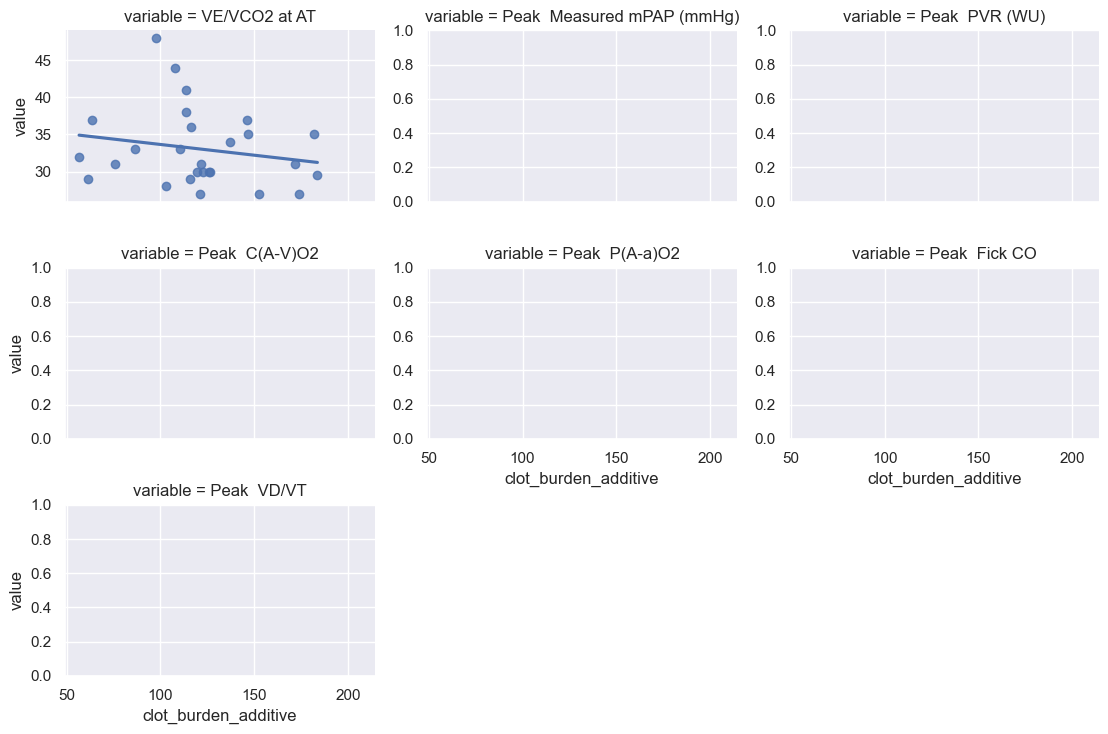

In [25]:
g = sns.lmplot(
    data=df_sub_long,
    x='clot_burden_additive',
    y='value',
    hue='Resolved',
    col='variable',
    col_wrap=3,
    height=2.5,
    aspect=1.5,
    facet_kws={'sharey': False},
)

# plt.savefig('output/plots/lm_clot_burden_v_relationships')